# Data Preparation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import glob
from qiskit import QuantumCircuit
from mqt.predictor import ml
from mqt.predictor import reward

# Read in quantum circuits and (calculate) scores
X, Y = [], []
for qasm_file in glob.glob("/home/ubuntu/mqt/mqt-predictor/src/mqt/predictor/ml/training_data/training_circuits/*.qasm"):
    qc = QuantumCircuit.from_qasm_file(qasm_file)
    feat_dict = ml.helper.create_feature_dict(qc)
    score = reward.crit_depth(qc) # more balanced than expected fidelity
    X.append(list(feat_dict.values()))
    Y.append(score)

# Split data into training and test set
X_train, X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]
Y_train, Y_test = Y[:int(len(Y)*0.8)], Y[int(len(Y)*0.8):]

/home/ubuntu/mqt/mqt-bench/src/mqt/bench/devices/rigetti.py:161: UserWarning: Rigetti device fidelity data is not available for some two-qubit gates.The average value of the available gates will be used for the missing ones.
  warnings.warn(msg, stacklevel=1)


In [2]:
for idx, train in enumerate(X_train):
    for idy, element in enumerate(train):
        if isinstance(element, list) or isinstance(element, np.ndarray):
            print("Error in training data at idx: ", idx, " and element idx: ", idy)

In [3]:
print(len(X_train), len(X_test))
print("Features: ", len(X_train[0]))

480 120
Features:  53


# Random Forest

In [4]:
clf = RandomForestRegressor(random_state=0)
tree_param = [
    {
        "n_estimators": [100, 200, 500],
        "max_depth": list(range(8, 30, 6)),
        "min_samples_split": list(range(2, 20, 6)),
        "min_samples_leaf": list(range(2, 20, 6)),
        "bootstrap": [True, False],
    },
]

clf = GridSearchCV(clf, tree_param, cv=3, n_jobs=-1).fit(X_train, Y_train)

y_pred = np.array(list(clf.predict(X_test)))

In [5]:
clf.best_params_

{'bootstrap': True,
 'max_depth': 14,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Time

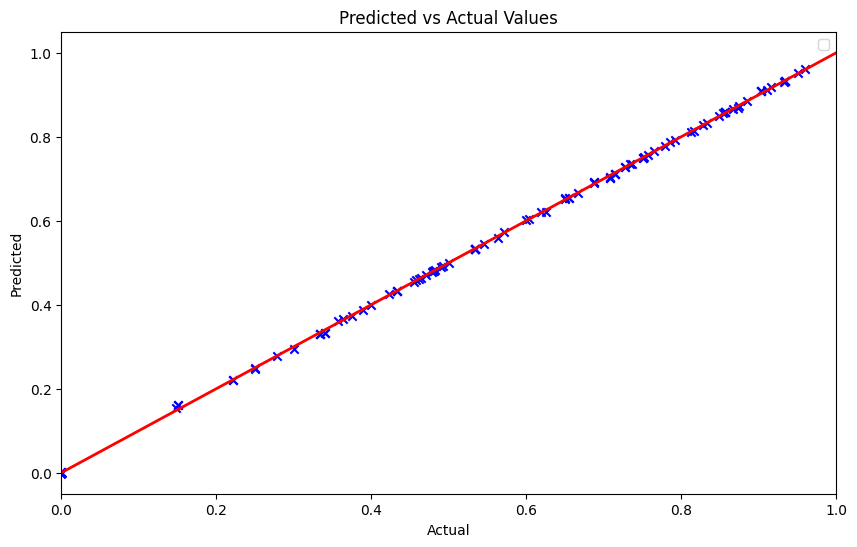

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, y_pred, color="blue", marker="x")
plt.plot([0, 1], [0, 1], color="red", linewidth=2)
plt.legend()
plt.xlim(0, 1)
plt.title("Predicted vs Actual Values")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

In [7]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Convert the model to ONNX
initial_type = [("float_input", FloatTensorType([None, len(X_train[0])]))]
onnx_model = convert_sklearn(clf, initial_types=initial_type)

# Save the model
with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())